# 05 StratifiedKFold: Pattern1 vs Pattern2(Adversarial Validation)

`00_prepare_data.ipynb` で作成した Titanic の Train/Test を使い、
- Pattern1: 特徴量をそのまま使う StratifiedKFold
- Pattern2: 各foldのTrain/Testで Adversarial Validation を行い、乖離特徴量を削除して StratifiedKFold
を比較します。

In [326]:
import os
import random
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, log_loss, roc_auc_score, roc_curve

SEED = 42
N_SPLITS = 5
ADV_AUC_THRESHOLD = 0.30
ADV_DROP_TOP_K = 5

os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [327]:
train_df = pd.read_csv('data/processed/classification_train.csv')
test_df = pd.read_csv('data/processed/classification_test.csv')

X_train_full = train_df.drop(columns=['target'])
y_train_full = train_df['target'].astype(int)
X_test = test_df.drop(columns=['target'])
y_test = test_df['target'].astype(int)

class_labels = np.sort(y_train_full.unique())
num_class = len(class_labels)

print(f'Train full shape: {X_train_full.shape}')
print(f'Test shape      : {X_test.shape}')
print('Train class ratio:', y_train_full.value_counts(normalize=True).sort_index().to_dict())
print('Test  class ratio:', y_test.value_counts(normalize=True).sort_index().to_dict())

Train full shape: (19536, 14)
Test shape      : (29306, 14)
Train class ratio: {0: 0.7606981981981982, 1: 0.2393018018018018}
Test  class ratio: {0: 0.6324643417730158, 1: 0.36753565822698425}


In [328]:
def build_multiclass_model(seed):
    return lgb.LGBMClassifier(
        objective='multiclass',
        num_class=num_class,
        n_estimators=120,
        learning_rate=0.05,
        num_leaves=7,
        min_child_samples=20,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=seed,
        bagging_seed=seed,
        feature_fraction_seed=seed,
        data_random_seed=seed,
        deterministic=True,
        force_col_wise=True
    )

def evaluate_split(split_name, y_true, pred, proba):
    return {
        'Split': split_name,
        'Accuracy': accuracy_score(y_true, pred),
        'F1_macro': f1_score(y_true, pred, average='macro'),
        'LogLoss': log_loss(y_true, proba, labels=class_labels)
    }

def plot_roc_feat(y_true, y_pred, est, cols, title_prefix='Adversarial Validation', x_max=1.0):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    ax[0].plot(fpr, tpr, label=f'AUC={auc:.3f}', marker='o', markersize=1)
    ax[0].legend()
    ax[0].grid()
    ax[0].plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), linestyle='--')
    ax[0].set_title(f'{title_prefix}: ROC curve')
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_xlim([-0.01, x_max])
    ax[0].set_ylabel('True Positive Rate')

    importance = pd.DataFrame({
        'feature': cols,
        'score': est.feature_importances_
    }).sort_values('score', ascending=False)

    top20 = importance.head(20).iloc[::-1]
    ax[1].barh(top20['feature'], top20['score'])
    ax[1].set_title(f'{title_prefix}: Top 20 Feature Importances')
    plt.tight_layout()
    plt.show()

    return auc, importance

def adversarial_drift_features(X_train_fold, X_test_ref, auc_threshold=ADV_AUC_THRESHOLD, top_k=ADV_DROP_TOP_K, draw_plot=False):
    adv_train = X_train_fold.copy()
    adv_test = X_test_ref.copy()
    adv_train['dataset_label'] = 0
    adv_test['dataset_label'] = 1
    adv_master = pd.concat([adv_train, adv_test], axis=0)

    adv_X = adv_master.drop(columns=['dataset_label'])
    adv_y = adv_master['dataset_label']

    adv_X_train, adv_X_test, adv_y_train, adv_y_test = train_test_split(
        adv_X, adv_y,
        test_size=0.4,
        stratify=adv_y,
        random_state=SEED
    )

    adv_model = lgb.LGBMClassifier(
        objective='binary',
        n_estimators=300,
        learning_rate=0.05,
        num_leaves=31,
        random_state=SEED,
        deterministic=True,
        force_col_wise=True
    )
    adv_model.fit(adv_X_train, adv_y_train)

    adv_pred = adv_model.predict_proba(adv_X_test)[:, 1]
    adv_auc = roc_auc_score(adv_y_test, adv_pred)

    importance = pd.DataFrame({
        'feature': adv_X.columns,
        'score': adv_model.feature_importances_
    }).sort_values('score', ascending=False)

    if draw_plot:
        _ = plot_roc_feat(adv_y_test, adv_pred, adv_model, adv_X.columns, title_prefix='Adversarial Validation')

    drift_features = []
    if adv_auc >= auc_threshold:
        drift_features = importance[importance['score'] > 0]['feature'].head(top_k).tolist()

    return adv_auc, drift_features

In [329]:
def run_stratified_kfold_pattern(method_name, use_adversarial_drop=False):
    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
    fold_rows = []
    test_proba_folds = []
    dropped_feature_records = []

    for fold, (tr_idx, va_idx) in enumerate(skf.split(X_train_full, y_train_full), start=1):
        X_tr = X_train_full.iloc[tr_idx].copy()
        y_tr = y_train_full.iloc[tr_idx].copy()
        X_va = X_train_full.iloc[va_idx].copy()
        y_va = y_train_full.iloc[va_idx].copy()
        X_te = X_test.copy()

        adv_auc = np.nan
        dropped_features = []

        if use_adversarial_drop:
            adv_auc, dropped_features = adversarial_drift_features(X_tr, X_te, draw_plot=(fold == 1))
            max_drop = max(0, X_tr.shape[1] - 1)
            dropped_features = dropped_features[:max_drop]

            if len(dropped_features) > 0:
                X_tr = X_tr.drop(columns=dropped_features, errors='ignore')
                X_va = X_va.drop(columns=dropped_features, errors='ignore')
                X_te = X_te.drop(columns=dropped_features, errors='ignore')

        model = build_multiclass_model(SEED + fold)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            eval_metric='multi_logloss'
        )

        tr_proba = model.predict_proba(X_tr)
        tr_pred = model.predict(X_tr)
        va_proba = model.predict_proba(X_va)
        va_pred = model.predict(X_va)
        te_proba = model.predict_proba(X_te)
        te_pred = np.argmax(te_proba, axis=1)

        test_proba_folds.append(te_proba)

        for metrics in [
            evaluate_split('Train', y_tr, tr_pred, tr_proba),
            evaluate_split('Valid', y_va, va_pred, va_proba),
            evaluate_split('Test', y_test, te_pred, te_proba)
        ]:
            row = {
                'Method': method_name,
                'Fold': fold,
                'Split': metrics['Split'],
                'Accuracy': metrics['Accuracy'],
                'F1_macro': metrics['F1_macro'],
                'LogLoss': metrics['LogLoss'],
                'AdvAUC': adv_auc,
                'DroppedFeatureCount': len(dropped_features)
            }
            fold_rows.append(row)

        dropped_feature_records.append({
            'Method': method_name,
            'Fold': fold,
            'AdvAUC': adv_auc,
            'DroppedFeatureCount': len(dropped_features),
            'DroppedFeatures': dropped_features
        })

    fold_df = pd.DataFrame(fold_rows)
    mean_df = fold_df.groupby(['Method', 'Split'], as_index=False)[['Accuracy', 'F1_macro', 'LogLoss']].mean()

    test_proba_mean = np.mean(np.stack(test_proba_folds, axis=0), axis=0)
    test_pred_mean = np.argmax(test_proba_mean, axis=1)

    drop_info_df = pd.DataFrame(dropped_feature_records)
    return fold_df, mean_df, test_pred_mean, test_proba_mean, drop_info_df

[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 15628, number of used features: 14
[LightGBM] [Info] Start training from score -0.273535
[LightGBM] [Info] Start training from score -1.429979
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] Start training from score -0.273515
[LightGBM] [Info] Start training from score -1.430043
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] Start training from score -0.273515
[LightGBM] [Info] Start training from score -1.430043
[LightGBM] [Info] Total Bins 671
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 14
[LightGBM] [Info] Start training from score -0.273515
[LightGBM] [Info] Start training from score -1.430043
[LightGBM] [Info] Total Bins 661
[LightGBM] [Info] Number of dat

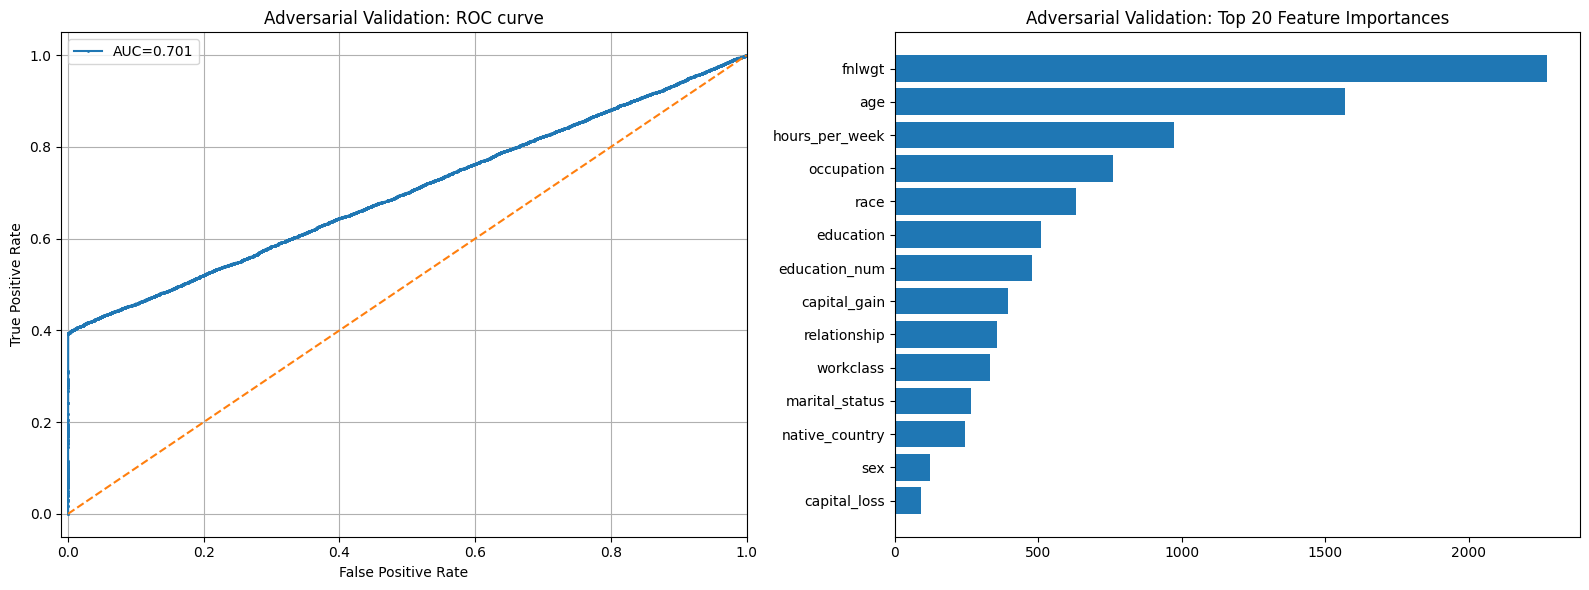

[LightGBM] [Info] Total Bins 242
[LightGBM] [Info] Number of data points in the train set: 15628, number of used features: 9
[LightGBM] [Info] Start training from score -0.273535
[LightGBM] [Info] Start training from score -1.429979
[LightGBM] [Info] Number of positive: 17584, number of negative: 9377
[LightGBM] [Info] Total Bins 1108
[LightGBM] [Info] Number of data points in the train set: 26961, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.652201 -> initscore=0.628730
[LightGBM] [Info] Start training from score 0.628730
[LightGBM] [Info] Total Bins 228
[LightGBM] [Info] Number of data points in the train set: 15629, number of used features: 9
[LightGBM] [Info] Start training from score -0.273515
[LightGBM] [Info] Start training from score -1.430043
[LightGBM] [Info] Number of positive: 17584, number of negative: 9377
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 26961, number of used features: 14
[LightGB

,Method,Fold,Split,Accuracy,F1_macro,LogLoss,AdvAUC,DroppedFeatureCount
0,Pattern1(StratifiedKFold),1,Train,0.863322,0.792410,0.298953,NaN,0
1,Pattern1(StratifiedKFold),1,Valid,0.863101,0.791036,0.293996,NaN,0
2,Pattern1(StratifiedKFold),1,Test,0.723708,0.711826,0.701165,NaN,0
3,Pattern1(StratifiedKFold),2,Train,0.865378,0.797312,0.296442,NaN,0
4,Pattern1(StratifiedKFold),2,Valid,0.860251,0.787407,0.300169,NaN,0


,Method,Fold,Split,Accuracy,F1_macro,LogLoss,AdvAUC,DroppedFeatureCount
0,Pattern2(StratifiedKFold+AdversarialDrop),1,Train,0.854236,0.775582,0.318500,0.700927,5
1,Pattern2(StratifiedKFold+AdversarialDrop),1,Valid,0.856704,0.779750,0.311741,0.700927,5
2,Pattern2(StratifiedKFold+AdversarialDrop),1,Test,0.727564,0.719241,0.752721,0.700927,5
3,Pattern2(StratifiedKFold+AdversarialDrop),2,Train,0.856101,0.779545,0.320297,0.700813,5
4,Pattern2(StratifiedKFold+AdversarialDrop),2,Valid,0.851804,0.772790,0.326014,0.700813,5


In [330]:
pattern1_fold_df, pattern1_mean_df, pattern1_test_pred, pattern1_test_proba, pattern1_drop_info = run_stratified_kfold_pattern(
    method_name='Pattern1(StratifiedKFold)',
    use_adversarial_drop=False
)

pattern2_fold_df, pattern2_mean_df, pattern2_test_pred, pattern2_test_proba, pattern2_drop_info = run_stratified_kfold_pattern(
    method_name='Pattern2(StratifiedKFold+AdversarialDrop)',
    use_adversarial_drop=True
)

display(pattern1_fold_df.head())
display(pattern2_fold_df.head())

In [331]:
comparison_df = pd.concat([pattern1_mean_df, pattern2_mean_df], ignore_index=True
)
comparison_df['Split'] = pd.Categorical(comparison_df['Split'], categories=['Train', 'Valid', 'Test'], ordered=True)
comparison_df = comparison_df.sort_values(['Split', 'Method']).reset_index(drop=True)
display(comparison_df)

pivot_acc = comparison_df.pivot(index='Split', columns='Method', values='Accuracy')
pivot_f1 = comparison_df.pivot(index='Split', columns='Method', values='F1_macro')
pivot_logloss = comparison_df.pivot(index='Split', columns='Method', values='LogLoss')

diff = pd.DataFrame({
    'Accuracy diff (Pattern2 - Pattern1)': pivot_acc['Pattern2(StratifiedKFold+AdversarialDrop)'] - pivot_acc['Pattern1(StratifiedKFold)'],
    'F1 diff (Pattern2 - Pattern1)': pivot_f1['Pattern2(StratifiedKFold+AdversarialDrop)'] - pivot_f1['Pattern1(StratifiedKFold)'],
    'LogLoss diff (Pattern2 - Pattern1)': pivot_logloss['Pattern2(StratifiedKFold+AdversarialDrop)'] - pivot_logloss['Pattern1(StratifiedKFold)']
}).reset_index()
print('Difference by split (Pattern2 - Pattern1)')
display(diff)

drop_summary = pattern2_drop_info[['Fold', 'AdvAUC', 'DroppedFeatureCount', 'DroppedFeatures']].copy()
print('Pattern2 adversarial validation summary')
display(drop_summary)
print('Dropped features by fold:')
for _, row in drop_summary.iterrows():
    fold = int(row['Fold'])
    drop_count = int(row['DroppedFeatureCount'])
    dropped = row['DroppedFeatures']
    print(f'Fold {fold}: dropped {drop_count} features -> {dropped}')

,Method,Split,Accuracy,F1_macro,LogLoss
0,Pattern1(StratifiedKFold),Train,0.864263,0.794303,0.296660
1,Pattern2(StratifiedKFold+AdversarialDrop),Train,0.855408,0.777627,0.317215
2,Pattern1(StratifiedKFold),Valid,0.861742,0.790250,0.302005
3,Pattern2(StratifiedKFold+AdversarialDrop),Valid,0.854013,0.775535,0.320915
4,Pattern1(StratifiedKFold),Test,0.722016,0.709259,0.711687
5,Pattern2(StratifiedKFold+AdversarialDrop),Test,0.727762,0.719469,0.733018


Difference by split (Pattern2 - Pattern1)


,Split,Accuracy diff (Pattern2 - Pattern1),F1 diff (Pattern2 - Pattern1),LogLoss diff (Pattern2 - Pattern1)
0,Train,-0.008855,-0.016676,0.020555
1,Valid,-0.007729,-0.014715,0.018910
2,Test,0.005746,0.010210,0.021330


Pattern2 adversarial validation summary


,Fold,AdvAUC,DroppedFeatureCount,DroppedFeatures
0,1,0.700927,5,"[fnlwgt, age, hours_per_week, occupation, race]"
1,2,0.700813,5,"[fnlwgt, age, hours_per_week, occupation, educ..."
2,3,0.697778,5,"[fnlwgt, age, hours_per_week, occupation, educ..."
3,4,0.698445,5,"[fnlwgt, age, hours_per_week, occupation, race]"
4,5,0.695617,5,"[fnlwgt, age, hours_per_week, occupation, educ..."


Dropped features by fold:
Fold 1: dropped 5 features -> ['fnlwgt', 'age', 'hours_per_week', 'occupation', 'race']
Fold 2: dropped 5 features -> ['fnlwgt', 'age', 'hours_per_week', 'occupation', 'education_num']
Fold 3: dropped 5 features -> ['fnlwgt', 'age', 'hours_per_week', 'occupation', 'education']
Fold 4: dropped 5 features -> ['fnlwgt', 'age', 'hours_per_week', 'occupation', 'race']
Fold 5: dropped 5 features -> ['fnlwgt', 'age', 'hours_per_week', 'occupation', 'education']


Test prediction agreement (Pattern1 vs Pattern2): 0.9294


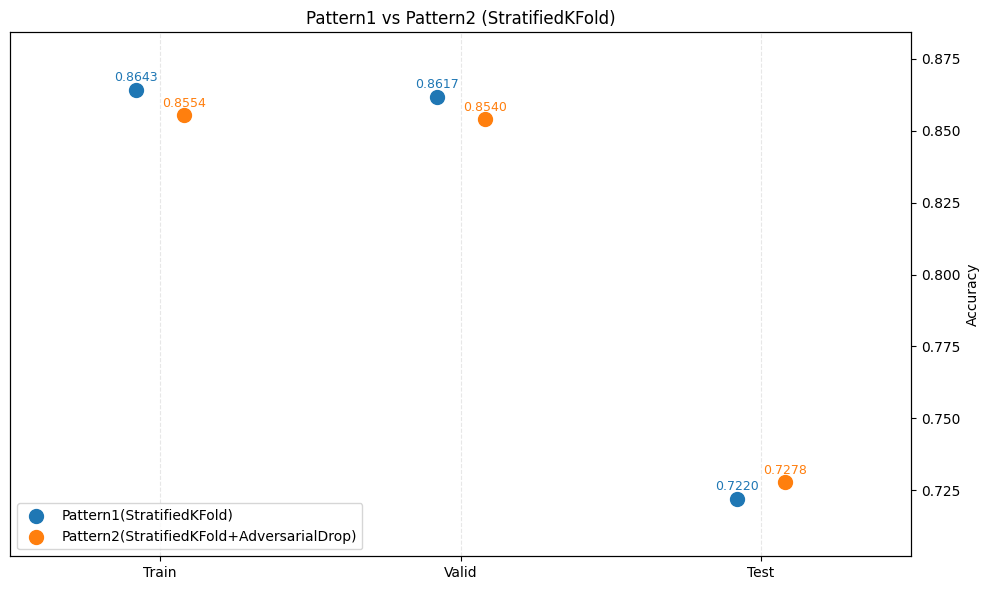

In [332]:
agreement = (pattern1_test_pred == pattern2_test_pred).mean()
print(f'Test prediction agreement (Pattern1 vs Pattern2): {agreement:.4f}')

split_order = ['Train', 'Valid', 'Test']
x = np.arange(len(split_order))
offset = 0.08

acc_p1 = [pivot_acc.loc[s, 'Pattern1(StratifiedKFold)'] for s in split_order]
acc_p2 = [pivot_acc.loc[s, 'Pattern2(StratifiedKFold+AdversarialDrop)'] for s in split_order]

fig, ax = plt.subplots(figsize=(10, 6))
ax_right = ax.twinx()

ax.set_xlim(-0.5, len(split_order) - 0.5)
ax.set_xticks(x)
ax.set_xticklabels(split_order)
ax.set_yticks([])
ax.set_ylabel('')
ax.grid(axis='x', linestyle='--', alpha=0.3)

ax_right.scatter(x - offset, acc_p1, s=100, label='Pattern1(StratifiedKFold)', color='tab:blue')
ax_right.scatter(x + offset, acc_p2, s=100, label='Pattern2(StratifiedKFold+AdversarialDrop)', color='tab:orange')

for i, score in enumerate(acc_p1):
    ax_right.text(x[i] - offset, score + 0.002, f'{score:.4f}', ha='center', va='bottom', fontsize=9, color='tab:blue')
for i, score in enumerate(acc_p2):
    ax_right.text(x[i] + offset, score + 0.002, f'{score:.4f}', ha='center', va='bottom', fontsize=9, color='tab:orange')

all_acc = np.array(acc_p1 + acc_p2)
ax_right.set_ylabel('Accuracy')
ax_right.set_ylim(max(0.0, all_acc.min() - 0.02), min(1.0, all_acc.max() + 0.02))
ax_right.legend(loc='lower left')

plt.title('Pattern1 vs Pattern2 (StratifiedKFold)')
plt.tight_layout()
plt.show()